# Are the SNe in DC2 found by the DRP pipeline?

### Load the butler for the DC2 processing and get the DC2 SN truth catalogs:

In [3]:
from lsst.daf.butler import Butler
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
import pandas as pd
import pyarrow.parquet as pq

In [4]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import lsst.geom
from astropy.time import Time

In [5]:
butler = Butler('/repo/dc2', collections="u/kherner/2.2i/runs/test20210807-tract4431-w32-step5")

In [8]:
snTruth = pq.read_table('/home/csaunder/stack_projects/DC2_supernovae/sn_truth_summary.parquet').to_pandas()
snTruth_lcs = pq.read_table('/home/csaunder/stack_projects/DC2_supernovae/sn_variability_truth.parquet').to_pandas()

### Get the DC2 tract information:

In [10]:
skymap = butler.get("skyMap")
tract = 4431
tractInfo = skymap.generateTract(tract)
tractWcs = tractInfo.getWcs()

### Get the SNe from the truth catalog that are in the Tract footprint:

In [27]:
sn_sps = np.array([lsst.geom.SpherePoint(sn['ra'], sn['dec'], lsst.geom.degrees) for s, sn in snTruth.iterrows()])
sn_tract = np.array([tractInfo.contains(lsst.geom.SpherePoint(sn['ra'], sn['dec'], lsst.geom.degrees)) for s, sn in snTruth.iterrows()])
sn_intract = snTruth[sn_tract]

In [8]:
sn_pixels = tractWcs.skyToPixelArray(sn_intract['ra'], sn_intract['dec'], degrees=True)

### Set up function to determine which SN lightcurve points should be in a given difference image and whether they are detected:

In [9]:
def find_detected_points(visit_list, band, max_visits=30):
    visit_points = []
    detected_points = []
    for vis in visit_list[:max_visits]:
        diffRefs = list(set(butler.registry.queryDatasets('goodSeeingDiff_differenceExp', dataId={'visit': vis})))
        print(vis, len(diffRefs))

        sample = butler.get(diffRefs[0])
        date = sample.getInfo().getVisitInfo().getDate()
        mjd = date.get(date.MJD)
        lc_points = snTruth_lcs[(snTruth_lcs['bandpass'] == diffRefs[0].dataId['band'])
                                & (abs(snTruth_lcs['MJD'] - mjd) < 0.0005)]
        # & (snTruth_lcs['MJD'] == mjd_match)]
        print(mjd, np.unique(lc_points['MJD']))
        point_check = 0
        print(mjd, len(lc_points))
        membership = sn_intract['id'].isin(lc_points['id'])
        vis_sne = sn_intract[membership]
        print(len(vis_sne), f'in this visit in {tract}')
        if len(vis_sne) == 0:
            print(len(lc_points))
            continue
        vis_x = sn_pixels[0][membership]
        vis_y = sn_pixels[1][membership]
        sne_cat = SkyCoord(vis_sne['ra'], vis_sne['dec'], unit=u.degree)
        # CHeck whether sn point is in diffIm, then whether it matches any detections
        plt.figure()
        plt.scatter(vis_sne['ra'], vis_sne['dec'], label='All SN points')
        print(f'Scanning {len(diffRefs)} images:')
        for diffRef in list(diffRefs):
            diffIm = butler.get('goodSeeingDiff_differenceExp', dataId=diffRef.dataId)
            diaSrc = butler.get('goodSeeingDiff_diaSrc', dataId=diffRef.dataId)
            diffIm_bbox = diffIm.getBBox()
            diffWcs = diffIm.getWcs()

            # Plot the image edges:
            xCorners = [diffIm_bbox.minX, diffIm_bbox.maxX, diffIm_bbox.maxX, diffIm_bbox.minX]
            yCorners = [diffIm_bbox.minY, diffIm_bbox.minY, diffIm_bbox.maxY, diffIm_bbox.maxY]
            raDecSPs = [diffWcs.pixelToSky(x, y) for (x, y) in zip(xCorners, yCorners)]
            raDecCorners = np.array([[sp.getRa().asDegrees(), sp.getDec().asDegrees()] for sp in raDecSPs])
            centerSP = diffWcs.pixelToSky(diffIm_bbox.centerX, diffIm_bbox.centerY)
            plt.plot(raDecCorners[:,0], raDecCorners[:,1])
            plt.text(centerSP.getRa().asDegrees(), centerSP.getDec().asDegrees(), diffRef.dataId['detector'])

            # Find SNe that should be in this image:
            det_x, det_y = diffWcs.skyToPixelArray(vis_sne['ra'], vis_sne['dec'], degrees=True)
            diffIm_sne = np.array([diffIm_bbox.contains(x, y) for (x, y) in zip(det_x, det_y)])

            # If there are any SNe, see if they are detected:
            if diffIm_sne.sum() > 0:
                diffIm_lc_points = lc_points[lc_points['id'].isin(vis_sne[diffIm_sne]['id'])]
                point_detects = np.zeros(len(diffIm_lc_points), dtype=bool)
                diaCat = SkyCoord(diaSrc['coord_ra'], diaSrc['coord_dec'], unit=u.radian)

                if (len(diaCat) == 0) or (len(sne_cat[diffIm_sne]) == 0): continue
                idx, d2d, d3d = sne_cat[diffIm_sne].match_to_catalog_sky(diaCat)
                print(f'Matched {(d2d.arcsecond < 1).sum()} out of {diffIm_sne.sum()} SNe in image')
                match_sne = vis_sne[diffIm_sne][d2d.arcsecond < 1]
                plt.scatter(match_sne['ra'], match_sne['dec'],
                            label=('Detected point' if point_check == 0 else None))
                match_membership = diffIm_lc_points['id'].isin(match_sne['id'])
                if len(match_sne) > 0:
                    print('Points matched:')
                    print(diffIm_lc_points[match_membership])
                point_check += len(match_sne)
                point_detects[match_membership] = True
                visit_points.append(diffIm_lc_points)
                detected_points.append(point_detects)
        plt.legend()
        plt.show()
    return visit_points, detected_points

## Compare truth catalogs with the DIA sources that are actually detected:

## R band:

diaSrcsR = list(set(butler.registry.queryDatasets('goodSeeingDiff_diaSrc', dataId={"band": "r", "skymap": 'DC2', "tract": tract})))
print(f"found {len(diaSrcsR)} diaSrcs in HSC-R")
rVisits = list(set(diaSrcR.dataId['visit'] for diaSrcR in diaSrcsR))
print(len(rVisits))
print(rVisits)

r_visit_points, r_detected_points = find_detected_points(rVisits, 'r')

allR_visit_points = pd.concat(r_visit_points)
allR_detected_points = np.concatenate(r_detected_points)
print(len(allR_visit_points), len(allR_detected_points))

### Which points are detected?

plt.hist(allR_visit_points['delta_flux'][allR_detected_points], alpha=0.5, bins=30, log=True, label='Detected');
plt.hist(allR_visit_points['delta_flux'][~allR_detected_points], alpha=0.5, bins=30, log=True, label='Not detected');
plt.legend()
plt.title('R band')
plt.xlabel('delta_flux')

## I band:

diaSrcsI = list(set(butler.registry.queryDatasets('goodSeeingDiff_diaSrc', dataId={"band": "i", "skymap": 'DC2', "tract": tract})))
print(f"found {len(diaSrcsI)} diaSrcs in HSC-I")
iVisits = list(set(diaSrcI.dataId['visit'] for diaSrcI in diaSrcsI))
print(len(iVisits))
print(iVisits)

i_visit_points, i_detected_points = find_detected_points(iVisits, 'i')

allI_visit_points = pd.concat(i_visit_points)
allI_detected_points = np.concatenate(i_detected_points)
print(len(allI_visit_points), len(allI_detected_points))

### Which points are detected?

plt.hist(allI_visit_points['delta_flux'][allI_detected_points], alpha=0.5, bins=30, log=True, label='Detected');
plt.hist(allI_visit_points['delta_flux'][~allI_detected_points], alpha=0.5, bins=30, log=True, label='Not detected');
plt.legend()
plt.title('I band')
plt.xlabel('delta_flux')

## Z band:

diaSrcsZ = list(set(butler.registry.queryDatasets('goodSeeingDiff_diaSrc', dataId={"band": "z", "skymap": 'DC2', "tract": tract})))
print(f"found {len(diaSrcsZ)} diaSrcs in HSC-Z")
zVisits = list(set(diaSrcZ.dataId['visit'] for diaSrcZ in diaSrcsZ))
print(len(zVisits))
print(zVisits)

z_visit_points, z_detected_points = find_detected_points(zVisits, 'z')

allZ_visit_points = pd.concat(z_visit_points)
allZ_detected_points = np.concatenate(z_detected_points)
print(len(allZ_visit_points), len(allZ_detected_points))

### Which points are detected?

plt.hist(allZ_visit_points['delta_flux'][allZ_detected_points], alpha=0.5, bins=30, log=True, label='Detected');
plt.hist(allZ_visit_points['delta_flux'][~allZ_detected_points], alpha=0.5, bins=30, log=True, label='Not detected');
plt.legend()
plt.title('Z band')
plt.xlabel('delta_flux')

# Which SNe are detected in the `assocDiaSrcTables`?

In [10]:
sn_patches = [tractInfo.findPatch(lsst.geom.SpherePoint(sn['ra'], sn['dec'], lsst.geom.degrees)) for s, sn in sn_intract.iterrows()]

In [11]:
minMJD = 59582.
maxMJD = 60310.
brightSN_points = snTruth_lcs[(snTruth_lcs['delta_flux'] > 1500) & (snTruth_lcs['MJD'] > minMJD)
                              & (snTruth_lcs['MJD'] < maxMJD)]
brightSN_ids = pd.unique(brightSN_points['id'])

membership = sn_intract['id'].isin(brightSN_ids)
brightSN = sn_intract[membership]
# Because I can't get sn_patches to convert to array preserving elements anymore:
#bright_patches = sn_patches[membership]
bright_patches = [sn_patches[m] for m in membership]

In [12]:
SN_points_r = snTruth_lcs[(snTruth_lcs['MJD'] > minMJD) & (snTruth_lcs['bandpass'] == 'r')
                              & (snTruth_lcs['MJD'] < maxMJD)]
SN_points_i = snTruth_lcs[(snTruth_lcs['MJD'] > minMJD) & (snTruth_lcs['bandpass'] == 'i')
                              & (snTruth_lcs['MJD'] < maxMJD)]
SN_points_z = snTruth_lcs[(snTruth_lcs['MJD'] > minMJD) & (snTruth_lcs['bandpass'] == 'z')
                              & (snTruth_lcs['MJD'] < maxMJD)]

Patch 27
There are 83 sne are in the truth catalog, of which 0 are bright (flux > 1500 in any band)
4 found in assocDiaSrcTable

Patch 37
There are 47 sne are in the truth catalog, of which 0 are bright (flux > 1500 in any band)
11 found in assocDiaSrcTable

Patch 11
There are 69 sne are in the truth catalog, of which 0 are bright (flux > 1500 in any band)
12 found in assocDiaSrcTable

Patch 46
There are 76 sne are in the truth catalog, of which 0 are bright (flux > 1500 in any band)
13 found in assocDiaSrcTable

Patch 26
There are 49 sne are in the truth catalog, of which 0 are bright (flux > 1500 in any band)
6 found in assocDiaSrcTable

Patch 30
There are 69 sne are in the truth catalog, of which 0 are bright (flux > 1500 in any band)
13 found in assocDiaSrcTable

Patch 33
There are 56 sne are in the truth catalog, of which 0 are bright (flux > 1500 in any band)
10 found in assocDiaSrcTable

Patch 36
There are 55 sne are in the truth catalog, of which 0 are bright (flux > 1500 in an

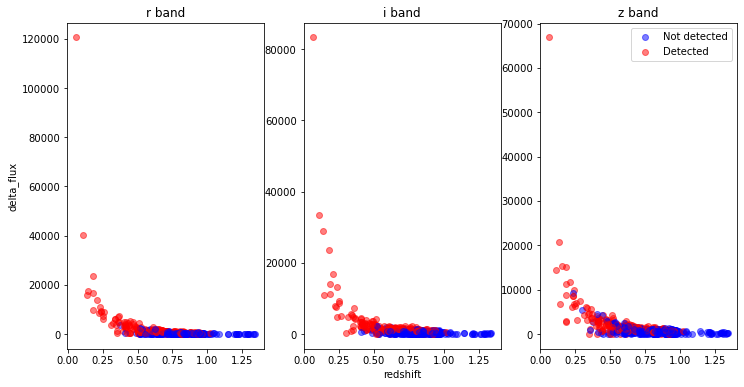

In [13]:
assocDiaSrcTableRefs = list(butler.registry.queryDatasets("goodSeeingDiff_assocDiaSrcTable"))
total_sne = 0
bright_count = 0
found_sne = 0
fig, subs = plt.subplots(1, 3, sharex=True, figsize=(12, 6))
for i, assocRef in enumerate(assocDiaSrcTableRefs):
    patch = assocRef.dataId['patch']
    print("Patch", patch)
    patchInd = tractInfo[patch].getIndex()
    sne = sn_intract[np.array([sn_patch.getIndex() == patchInd for sn_patch in sn_patches])].reset_index()
    sn_maxes = np.zeros((len(sne), 3))
    for s, sn in sne.iterrows():
        match_r = SN_points_r[SN_points_r['id'] == sn['id']]
        match_i = SN_points_i[SN_points_i['id'] == sn['id']]
        match_z = SN_points_z[SN_points_z['id'] == sn['id']]
        sn_maxes[s, 0] = match_r['delta_flux'].max()
        sn_maxes[s, 1] = match_i['delta_flux'].max()
        sn_maxes[s, 2] = match_z['delta_flux'].max()

    bright_sne = np.array([sn_patch.getIndex() == patchInd for sn_patch in bright_patches])
    bright_count += bright_sne.sum()
    truth_cat = SkyCoord(ra=sne['ra'], dec=sne['dec'], unit=u.degree)
    print(f'There are {len(sne)} sne are in the truth catalog, of which {bright_sne.sum()} are bright (flux > 1500 in any band)')
    total_sne += len(sne)
    assocObjTable = butler.get(assocRef)
    assocObj_cat = SkyCoord(ra=assocObjTable['ra'], dec=assocObjTable['decl'], unit=u.degree)
    idx, d2d, d3d = truth_cat.match_to_catalog_sky(assocObj_cat)
    found = (d2d.arcsecond < 0.5).sum()
    for s in range(3):
        subs[s].scatter(sne['redshift'][d2d.arcsecond >= 0.5], sn_maxes[d2d.arcsecond >= 0.5, s], color='blue', alpha=0.5, label=('Not detected' if i == 0 else None))
        subs[s].scatter(sne['redshift'][d2d.arcsecond < 0.5], sn_maxes[d2d.arcsecond < 0.5, s], color='red', alpha=0.5, label=('Detected' if i == 0 else None))
    print(found, 'found in assocDiaSrcTable\n')
    found_sne += found
subs[0].set_title('r band')
subs[1].set_title('i band')
subs[2].set_title('z band')
subs[1].set_xlabel('redshift')
subs[0].set_ylabel('delta_flux')
plt.legend()
print('Total:', total_sne)
print("Bright:", bright_count)
print('Found:', found_sne)

# What do the SN points look like in the calexps and difference images?

In [47]:
cnum = 300

In [48]:
calexps = set(butler.registry.queryDatasets('calexp', dataId={"band": "r", "skymap": 'DC2', "tract": tract, "patch": 19}))
print(f"found {len(calexps)} calexps")
#calexps_full = [butler.get('calexp', dataId=calDataId.dataId) for calDataId in list(calexps)]
calexps_full = []
calexps = sorted(list(calexps), key=lambda calexp: calexp.dataId['visit'])
print([c.dataId['visit'] for c in calexps[:20]])
for c, calDataId in enumerate(calexps[:cnum]):
    if not c % 5: print(c) 
    calexps_full.append(butler.get('calexp', dataId=calDataId.dataId))

found 612 calexps
[162700, 162700, 181870, 181870, 181901, 181901, 181901, 181901, 181938, 181938, 181938, 181938, 193112, 193112, 193112, 193112, 193112, 193112, 193145, 193145]
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295


In [49]:
dates = [calexp.getInfo().getVisitInfo().getDate() for calexp in calexps_full]
mjds = [date.get(date.MJD) for date in dates]

In [50]:
mjds = np.array(mjds)

In [51]:
calexp_vis = np.array([calexp.dataId['visit'] for calexp in calexps[:cnum]])
calexp_ccd = np.array([calexp.dataId['detector'] for calexp in calexps[:cnum]])

In [52]:
diffs = []
for c, calRef in enumerate(list(calexps)[:cnum]):
    diffs.append(butler.get('goodSeeingDiff_differenceExp', dataId=calRef.dataId))
    if not c % 5: print(c)
#diffs = [butler.get('goodSeeingDiff_differenceExp', dataId=calRef.dataId) for calRef in list(calexps)[:cnum]]

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295


In [53]:
dia_srcs = np.array([butler.get('goodSeeingDiff_diaSrc', dataId=calexp.dataId) for calexp in calexps[:cnum]])

/tmp/ipykernel_2321806/1014434947.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dia_srcs = np.array([butler.get('goodSeeingDiff_diaSrc', dataId=calexp.dataId) for calexp in calexps[:cnum]])


In [54]:
assocDiaSrcs = butler.get('goodSeeingDiff_assocDiaSrcTable', dataId={"skymap": 'DC2', "tract": tract, "patch": 19})

In [41]:
def boxContains(box, point2d):
    newPoint = lsst.geom.Point2I(int(point2d.x), int(point2d.y))
    return box.contains(newPoint)

In [42]:
def makeCutout(detection, expF, ext=30):
    cutoutSize = lsst.geom.Extent2I(ext, ext)
    try:
        cutoutCenter = lsst.geom.SpherePoint(detection['ra'], detection['decl'], lsst.geom.degrees)
    except:
        cutoutCenter = lsst.geom.SpherePoint(detection['ra'], detection['dec'], lsst.geom.degrees)
        cutout = expF.getCutout(cutoutCenter, cutoutSize)
    return cutout

In [55]:
bboxes = [cal.getBBox() for cal in calexps_full]
wcss = [cal.getWcs() for cal in calexps_full]

In [56]:
invis_tots = []
patch_sne = []
patch_sne_visits = []
for s, sn in sn_intract.iterrows():
    sp = lsst.geom.SpherePoint(sn['ra'], sn['dec'], lsst.geom.degrees)
    #if not boxContains(patchBBox, tractWcs.skyToPixel(sp)):
    #    continue
    #print(s)
    inVisits = np.array([boxContains(bboxes[j], wcss[j].skyToPixel(sp)) for j in range(len(calexp_vis))])
    invis_tots.append(inVisits.sum())
    if inVisits.sum() > 0:
        patch_sne.append(sn)
        patch_sne_visits.append(inVisits)
print(len(patch_sne), 'test sne')

713 test sne


In [59]:
foundSN = 0
match_sne = []
match_sne_idx = []
for s, testSN in enumerate(patch_sne):
    print(s)
    testSN_visits = patch_sne_visits[s]

    match_calexps = np.array(calexps_full)[testSN_visits]
    match_diffs = np.array(diffs)[testSN_visits]
    match_visits = calexp_vis[testSN_visits]
    match_mjds = mjds[testSN_visits]

    testLC = snTruth_lcs[snTruth_lcs['id'] == testSN['id']]
    testLC_r = testLC[testLC['bandpass'] == 'r'].reset_index()
    
    close_mjds = np.zeros(len(testLC_r))
    for i, obs in testLC_r.iterrows():
        best_match = min(abs(match_mjds - obs['MJD']))
        close_mjds[i] = best_match
    if (close_mjds < 1).sum() > 0:
        match_sne.append(testSN)
        match_sne_idx.append(s)
        print(f'\nSN', s, testSN['id'])
        print(f'SN is in {len(match_calexps)} calexps')
        print(f'SN true lc has {len(testLC)} points, of which {len(testLC_r)} are in r-band')
        print("match mjds:", match_mjds[match_mjds.argsort()])
        print("lc mjds:", np.array(testLC_r['MJD']))
        print(close_mjds)
        print(f'Close mjd matches: {(close_mjds < .1).sum()}')
        print('Flux max:', testLC_r['delta_flux'].max())
        if testLC_r['delta_flux'].max() > 200:
            foundSN += 1
    if foundSN == 15:
        break

0
1
2
3
4
5
6
7
8
9

SN 9 hl_ms_16283
SN is in 24 calexps
SN true lc has 44 points, of which 7 are in r-band
match mjds: [59798.31601122 59821.30823522 59839.31746222 59867.21775522
 59877.13771622 59877.17016722 59929.12611822 60001.07592822
 60166.41168122 60166.41306022 60175.31590422 60175.33610622
 60175.33655522 60224.16011322 60234.14189022 60234.15917922
 60240.13528822 60531.32797922 60583.32928422 60584.22903122
 60584.25523222 60605.19969522 60605.31614522 60647.10878022]
lc mjds: [60143.424578 60166.411334 60166.412713 60175.315111 60175.315557
 60175.335759 60175.336208]
[2.29871032e+01 3.47224537e-04 3.47221066e-04 7.93223371e-04
 3.47223373e-04 3.47224537e-04 1.01775462e-04]
Close mjd matches: 6
Flux max: 316.9129333496094
10
11
12
13
14
15
16
17
18
19

SN 19 hl_ms_22504
SN is in 39 calexps
SN true lc has 39 points, of which 7 are in r-band
match mjds: [59821.29100122 59839.31746222 59840.36790822 59849.20118222
 59867.21775522 59867.22118122 59867.24523122 59868.1313742

43
44

SN 44 hl_ms_59906
SN is in 53 calexps
SN true lc has 99 points, of which 25 are in r-band
match mjds: [59798.31601122 59821.27691922 59821.29100122 59821.30823522
 59839.31746222 59839.33315422 59840.27321622 59840.36790822
 59844.24597422 59844.24642222 59849.20118222 59867.22118122
 59868.13137422 59868.14849222 59877.13771622 59877.17016722
 59929.12611822 60001.07592822 60143.42492522 60166.41168122
 60166.41306022 60175.31545822 60175.31590422 60175.33655522
 60206.23248722 60224.16011322 60224.18252322 60232.13162122
 60232.14936722 60232.15479922 60232.17200622 60234.14233722
 60234.15828422 60234.15873322 60240.13528822 60240.20462222
 60531.32797922 60531.37497422 60536.29552422 60578.31825022
 60578.35116622 60578.37773222 60583.29766322 60583.32928422
 60584.20400322 60584.22903122 60605.19969522 60605.29701122
 60605.31141122 60606.21016422 60606.22184522 60606.22325022
 60606.23864722]
lc mjds: [60578.317903 60578.350819 60578.377385 60583.297316 60583.328937
 60584

74

SN 74 hl_ms_78068
SN is in 56 calexps
SN true lc has 56 points, of which 14 are in r-band
match mjds: [59798.31601122 59821.29100122 59821.30823522 59839.31746222
 59839.33315422 59840.27321622 59840.36790822 59844.24642222
 59867.21775522 59867.22118122 59868.13137422 59868.14849222
 59877.13771622 59877.17016722 59926.15045022 59929.12611822
 60001.07592822 60143.42492522 60166.41168122 60166.41306022
 60175.31545822 60175.31590422 60175.33610622 60175.33655522
 60206.23248722 60206.23293422 60211.24976922 60211.26834822
 60224.16011322 60224.18252322 60232.13162122 60232.13206922
 60232.15479922 60232.17245322 60234.14323222 60234.15828422
 60234.15873322 60234.15917922 60240.13528822 60240.20462222
 60531.32797922 60531.37497422 60578.31825022 60583.29766322
 60583.32928422 60584.20400322 60584.22903122 60584.25523222
 60605.19969522 60605.29701122 60605.31141122 60605.31614522
 60606.21016422 60606.22184522 60606.22325022 60647.10878022]
lc mjds: [59798.315664 59821.276572 598

160
161
162
163
164
165
166
167
168
169
170
171
172
173
174

SN 174 MS_9427_416
SN is in 21 calexps
SN true lc has 63 points, of which 16 are in r-band
match mjds: [59821.27691922 59821.30823522 59839.33315422 59868.13137422
 59877.12723322 59877.13771622 59877.17016722 59926.15045022
 59926.16593622 60001.07592822 60166.41168122 60175.31590422
 60175.33610622 60232.14936722 60234.15828422 60234.15873322
 60240.13528822 60240.20462222 60578.37773222 60583.29766322
 60606.21016422]
lc mjds: [60143.424578 60166.411334 60166.412713 60175.315111 60175.315557
 60175.335759 60175.336208 60175.336658 60206.23214  60206.232587
 60211.249422 60211.268001 60223.37501  60224.159766 60224.18173
 60224.182176]
[2.29871032e+01 3.47224537e-04 1.03177546e-03 7.93223371e-04
 3.47223373e-04 3.47224537e-04 1.01775462e-04 5.51775462e-04
 2.59172272e+01 2.59167802e+01 2.08999452e+01 2.08813662e+01
 8.77435722e+00 7.98960122e+00 7.96763722e+00 7.96719122e+00]
Close mjd matches: 7
Flux max: 2449.93798828125


hl_ms_16283 54.82459590966519 -32.03035888256956
Subplot 8, flux=80.92118072509766
Subplot 9, flux=80.91661071777344
Subplot 10, flux=62.314884185791016
Subplot 11, flux=62.286006927490234
Subplot 12, flux=62.286006927490234


/software/lsstsw/stack_20210813/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/software/lsstsw/stack_20210813/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


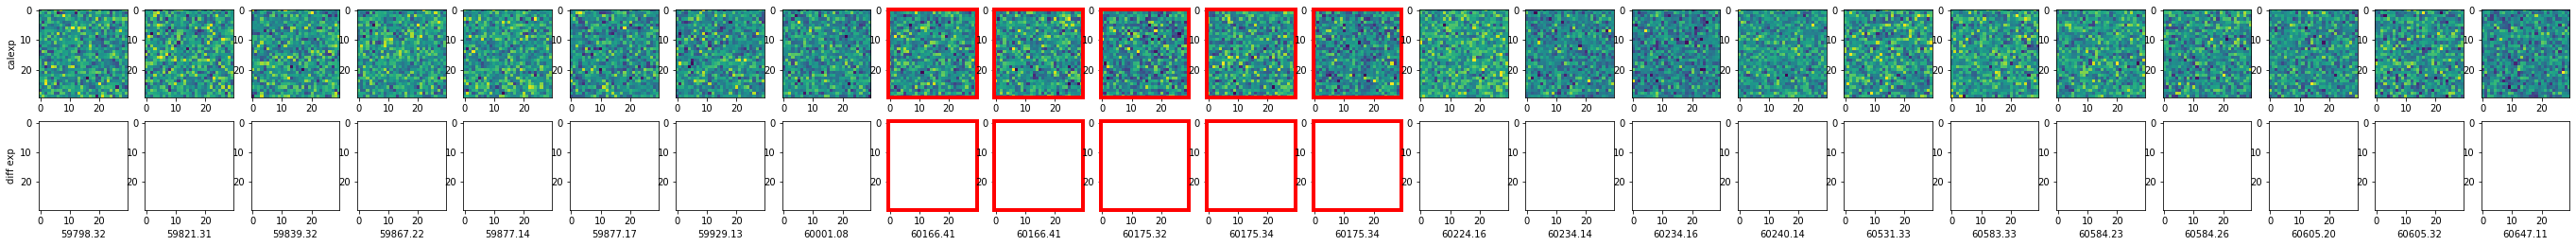

hl_ms_22504 55.38732837846803 -32.24369139661124
Subplot 16, flux=39.77645492553711
Subplot 17, flux=15.758522033691406
Subplot 18, flux=15.758522033691406
Subplot 19, flux=15.75288200378418


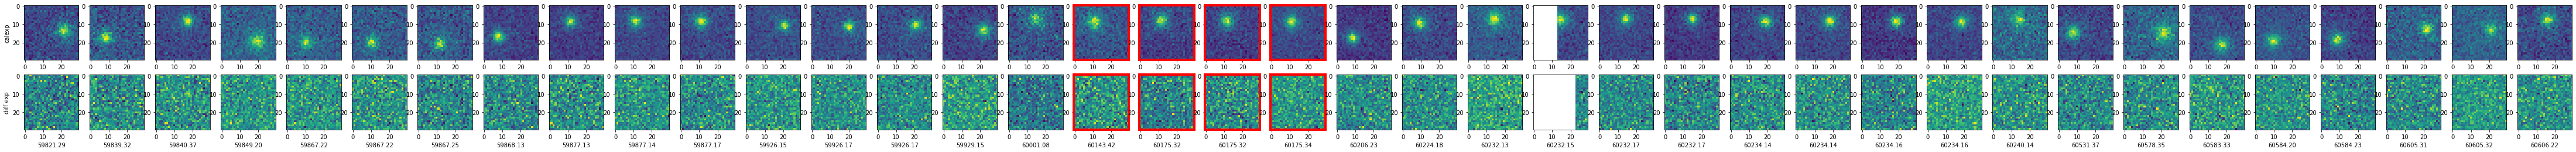

hl_ms_26748 55.270951216375124 -32.133027746805155
Subplot 28, flux=2.781745672225952
Subplot 29, flux=2.8044040203094482
Subplot 30, flux=61.64376449584961
Subplot 31, flux=61.94145584106445
Subplot 32, flux=62.035003662109375
Subplot 33, flux=62.33924102783203
Subplot 34, flux=62.33924102783203
Subplot 35, flux=98.352294921875
Subplot 36, flux=98.67058563232422
Subplot 37, flux=98.67925262451172
Subplot 38, flux=240.8998260498047


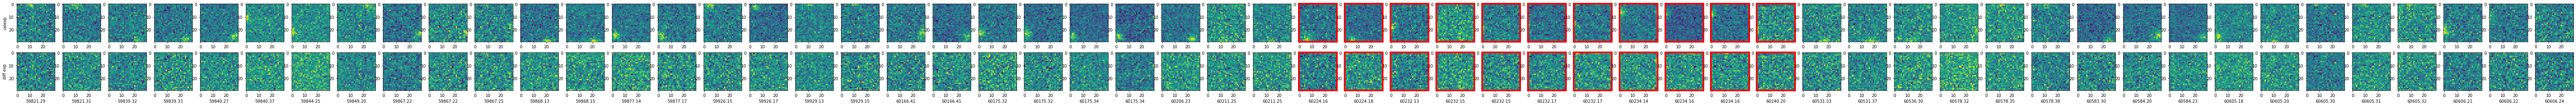

hl_ms_32520 54.98842497251981 -32.12985219273374
Subplot 16, flux=23.39713478088379
Subplot 17, flux=512.5820922851562
Subplot 18, flux=512.5767211914062
Subplot 19, flux=375.146240234375
Subplot 20, flux=375.146240234375
Subplot 21, flux=374.7432861328125
Subplot 22, flux=374.7432861328125
Subplot 23, flux=58.95075988769531
Subplot 24, flux=58.95075988769531
Subplot 25, flux=43.93073654174805
Subplot 26, flux=20.531213760375977
Subplot 27, flux=20.52338981628418
Subplot 28, flux=20.577747344970703
Subplot 29, flux=20.577747344970703
Subplot 30, flux=20.58428955078125
Subplot 31, flux=20.586339950561523
Subplot 32, flux=20.59299659729004
Subplot 33, flux=20.59299659729004
Subplot 34, flux=21.226200103759766
Subplot 35, flux=21.22960090637207
Subplot 36, flux=21.229698181152344
Subplot 37, flux=21.229698181152344
Subplot 38, flux=20.65807342529297


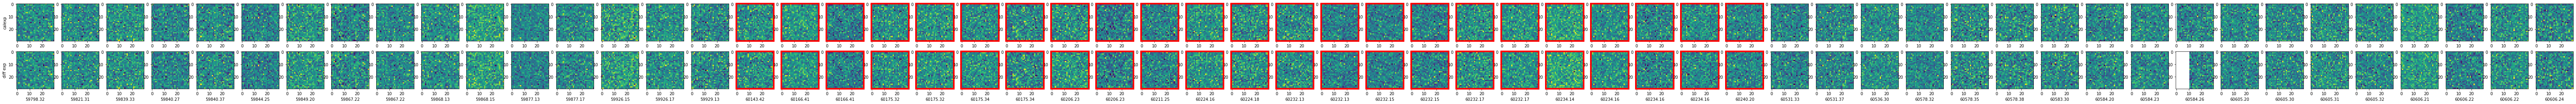

hl_ms_41060 54.88631943637266 -32.34134204526141
Subplot 4, flux=3.8153748512268066
Subplot 5, flux=4.8636064529418945
Subplot 6, flux=17.077613830566406
Subplot 7, flux=59.2275276184082
Subplot 8, flux=220.35325622558594
Subplot 9, flux=213.6793670654297
found diasrc match 1
Subplot 10, flux=118.92101287841797
Subplot 11, flux=118.82203674316406
Subplot 12, flux=118.5160140991211
Subplot 13, flux=9.520320892333984
Subplot 14, flux=9.518770217895508
Subplot 15, flux=9.247331619262695


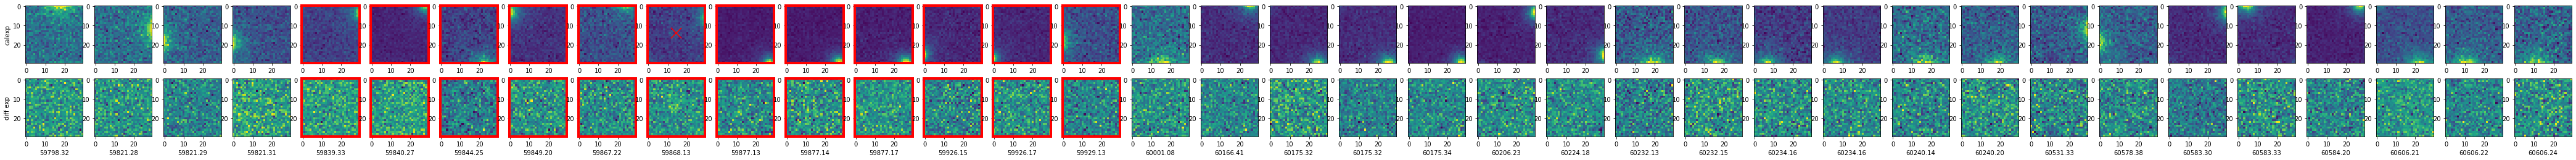

hl_ms_45110 55.44183623277543 -32.301465642234184
Subplot 22, flux=0.00032923766411840916
Subplot 23, flux=0.00033084466122090816
Subplot 24, flux=0.00042615868733264506
Subplot 25, flux=42.502891540527344
Subplot 26, flux=43.441001892089844
Subplot 27, flux=51.47966384887695


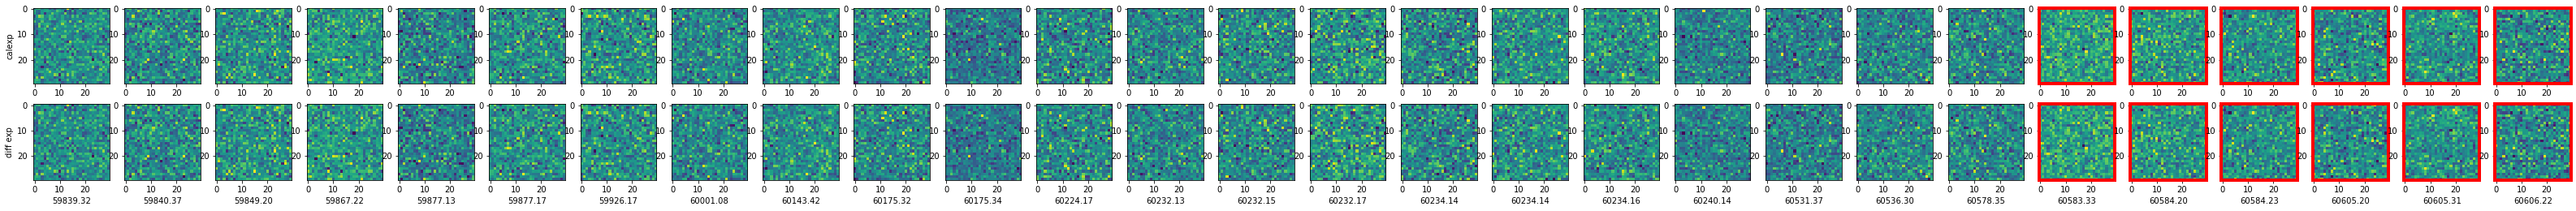

hl_ms_55009 55.073667829062565 -31.943748998400135
Subplot 25, flux=49.464027404785156
Subplot 26, flux=40.008445739746094
Subplot 27, flux=39.89305877685547
Subplot 28, flux=12.062911033630371
Subplot 29, flux=12.053607940673828
Subplot 30, flux=11.47562313079834
Subplot 31, flux=2.0339577198028564


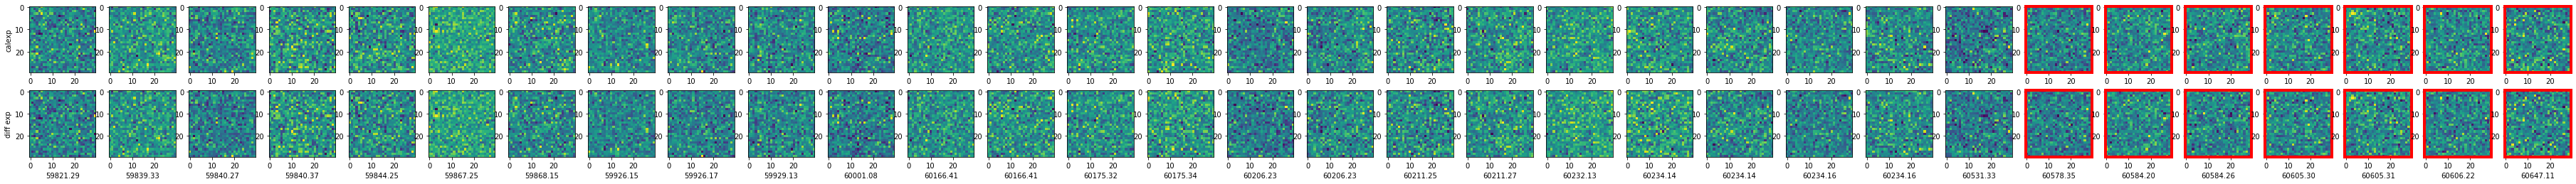

hl_ms_59906 55.10101487821129 -32.331961599558625
Subplot 39, flux=9.26085090637207
Subplot 40, flux=9.311866760253906
Subplot 41, flux=9.353126525878906
Subplot 42, flux=18.538719177246094
Subplot 43, flux=18.609697341918945
Subplot 44, flux=20.540037155151367
Subplot 45, flux=20.593704223632812
Subplot 46, flux=23.567882537841797
Subplot 47, flux=23.4395751953125
Subplot 48, flux=23.420547485351562
Subplot 49, flux=22.204593658447266
Subplot 50, flux=22.188400268554688
Subplot 51, flux=22.186452865600586
Subplot 52, flux=22.165090560913086


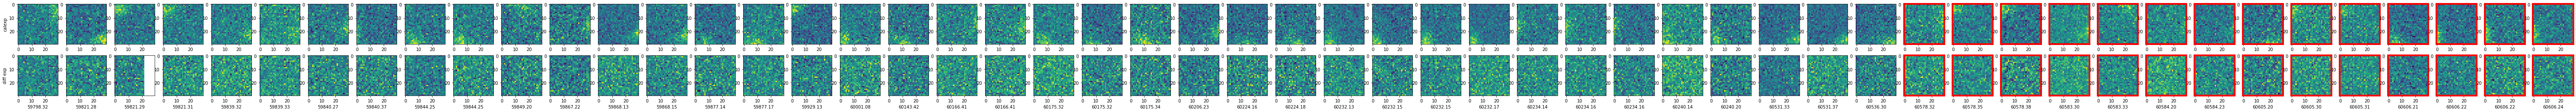

hl_ms_61521 55.10160352031486 -32.46691805436113
Subplot 0, flux=8.864319801330566
Subplot 1, flux=8.894723892211914
Subplot 2, flux=10.83121395111084
Subplot 3, flux=20.661914825439453
Subplot 4, flux=33.503936767578125
Subplot 5, flux=60.81425476074219
Subplot 6, flux=59.37375259399414
Subplot 7, flux=35.978729248046875
Subplot 8, flux=35.914119720458984
Subplot 9, flux=2.3456456661224365
Subplot 10, flux=2.341787099838257


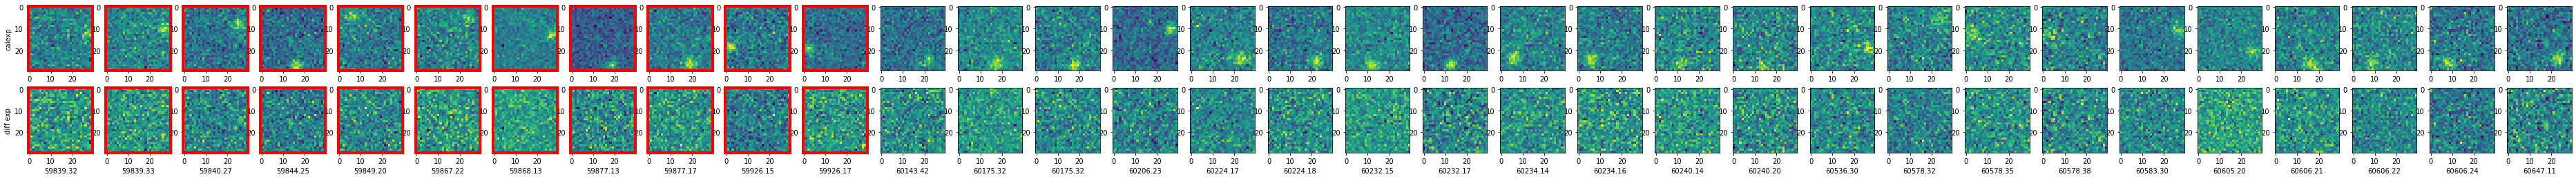

hl_ms_67180 55.05588800240139 -32.25448201027507
Subplot 19, flux=3.1822211742401123
Subplot 20, flux=3.2096667289733887
Subplot 21, flux=3.210049629211426
Subplot 22, flux=1.1480528116226196
Subplot 23, flux=1.1480528116226196
Subplot 24, flux=1.1450181007385254
Subplot 25, flux=1.1450181007385254
Subplot 26, flux=1.9926319122314453
Subplot 27, flux=1.9926319122314453
Subplot 28, flux=2.276562452316284
Subplot 29, flux=1.6385291814804077
Subplot 30, flux=1.6385291814804077
Subplot 31, flux=1.6363487243652344
Subplot 32, flux=1.63465416431427
Subplot 33, flux=1.63465416431427
Subplot 34, flux=1.439629077911377
Subplot 35, flux=1.439584493637085


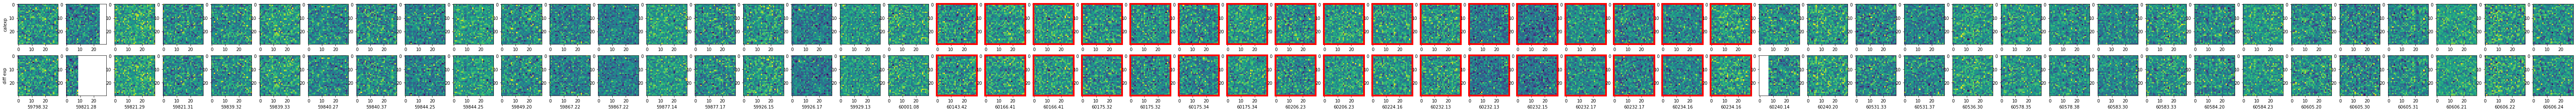

hl_ms_71735 54.87472020765273 -32.199941452880424
Subplot 0, flux=1.4096052646636963


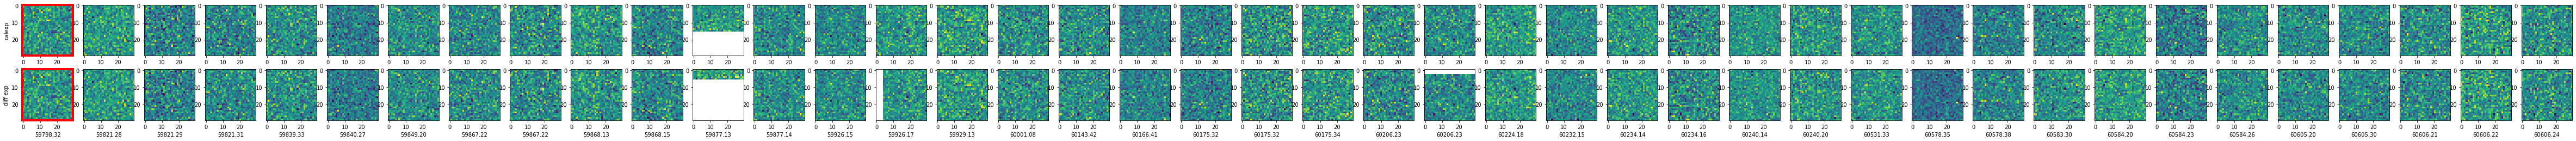

hl_ms_73369 54.77349313326902 -32.307293212670686
Subplot 0, flux=0.017079230397939682
Subplot 1, flux=0.01726529374718666
Subplot 2, flux=4.095538139343262
Subplot 3, flux=0.3546876311302185
Subplot 4, flux=0.36943233013153076


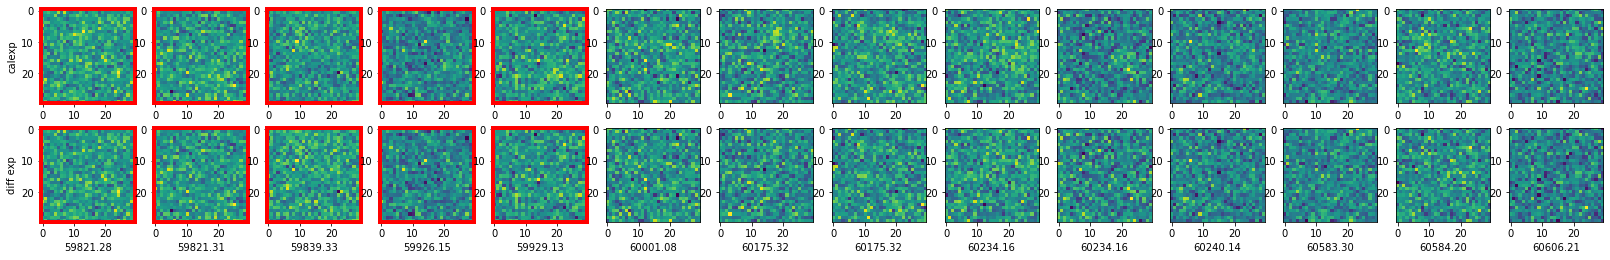

hl_ms_76705 55.21708692533116 -31.971952500632543
Subplot 17, flux=45.535400390625
Subplot 18, flux=5.337578296661377
Subplot 19, flux=5.3365912437438965
Subplot 20, flux=2.2509915828704834
Subplot 21, flux=2.2509915828704834
Subplot 22, flux=0.7816921472549438
Subplot 23, flux=0.8031407594680786
Subplot 24, flux=0.8039296269416809
Subplot 25, flux=0.5174461603164673
Subplot 26, flux=0.43630683422088623
Subplot 27, flux=0.4362523555755615
Subplot 28, flux=0.4356045722961426
Subplot 29, flux=0.4356045722961426
Subplot 30, flux=0.2336600124835968


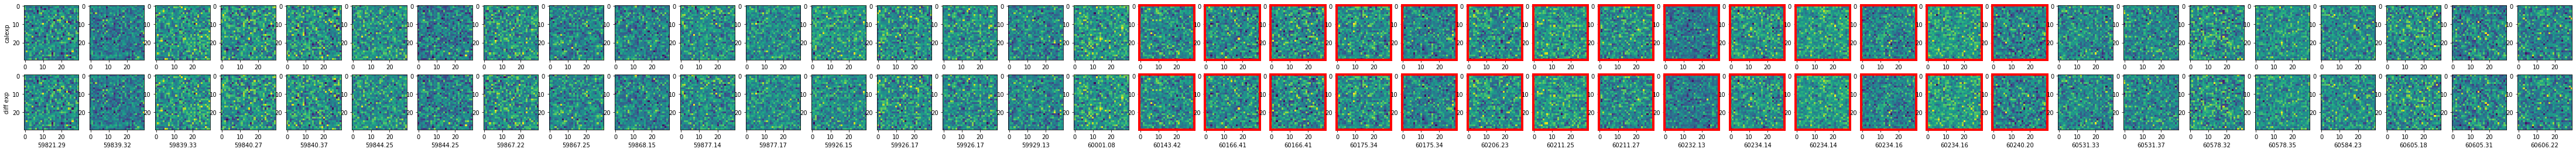

hl_ms_78068 54.98278355109021 -32.05764444693202
Subplot 0, flux=0.2507832646369934
Subplot 1, flux=0.9036587476730347
Subplot 2, flux=0.9036973714828491
Subplot 3, flux=0.9385963678359985
Subplot 4, flux=0.9384372234344482
Subplot 5, flux=0.927747368812561
Subplot 6, flux=0.9265443682670593
Subplot 7, flux=0.8588957786560059


/software/lsstsw/stack_20210813/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/software/lsstsw/stack_20210813/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


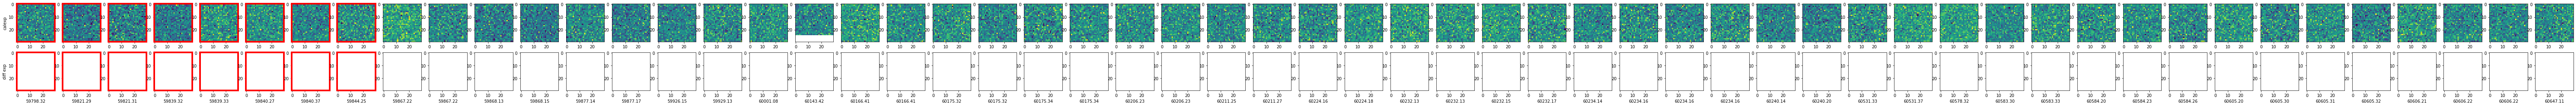

hl_ms_82400 54.936126253012965 -31.972508214584902
Subplot 21, flux=0.930456280708313
Subplot 22, flux=0.007836825214326382
Subplot 23, flux=0.00781878549605608
Subplot 24, flux=0.007354914676398039
Subplot 25, flux=0.007329693995416164


/software/lsstsw/stack_20210813/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/software/lsstsw/stack_20210813/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


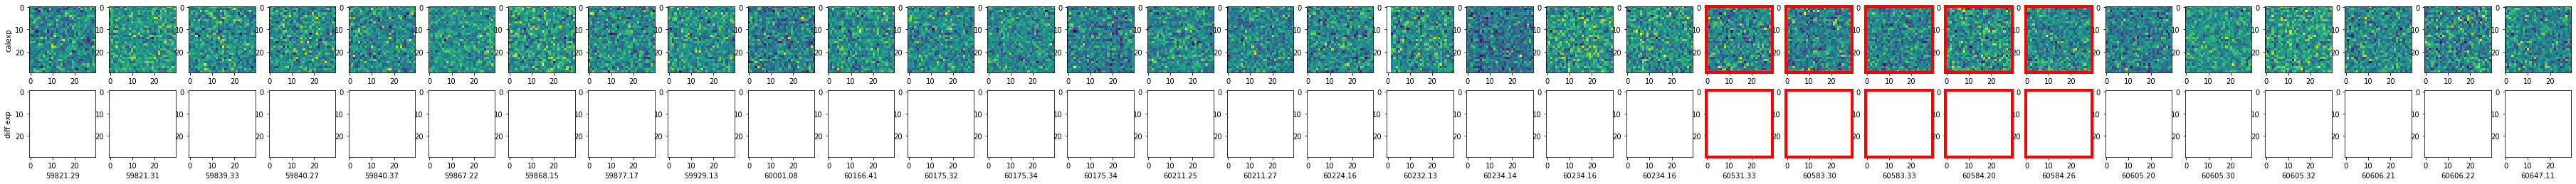

MS_9300_895 55.51627287782116 -31.974560241434826
Subplot 3, flux=2869.610595703125
found diasrc match 1
Subplot 4, flux=2870.7099609375


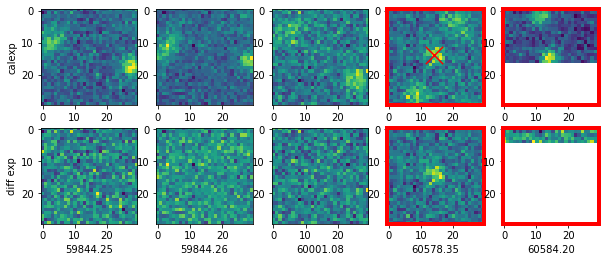

MS_9300_1551 55.534276907615286 -32.066143273035955
Subplot 5, flux=52.598079681396484


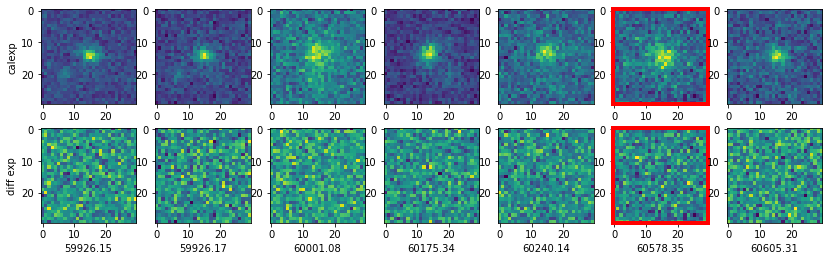

MS_9300_2185 55.60350046764671 -32.112611613319565
Subplot 0, flux=141.09225463867188
Subplot 1, flux=35.766014099121094


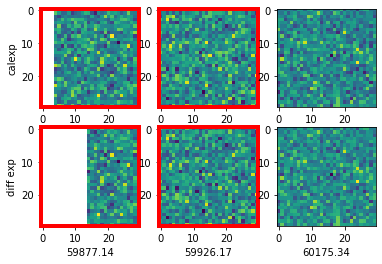

MS_9300_2729 55.6374953232439 -32.11599631296992
MS_9300_2733 55.48664861898645 -31.89464549646153
MS_9300_2886 55.49857741441084 -31.994813937493312
Subplot 2, flux=0.6426562666893005
Subplot 3, flux=0.649033784866333
Subplot 4, flux=34.38224792480469


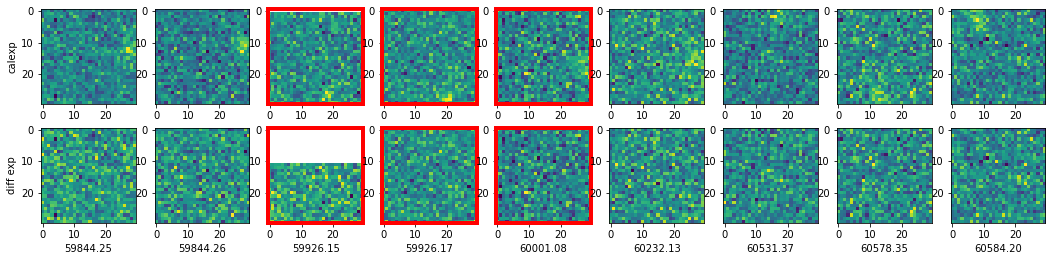

MS_9427_18 55.176024052096594 -32.5750107518662
Subplot 0, flux=1853.7305908203125
found diasrc match 1
Subplot 1, flux=1911.177734375
found diasrc match 1
Subplot 2, flux=16025.6748046875
found diasrc match 1
Subplot 3, flux=16016.16796875
found diasrc match 1


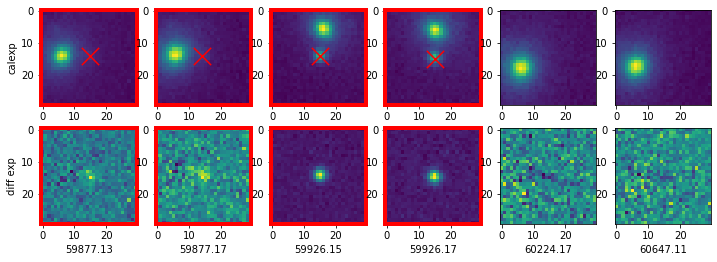

MS_9427_240 54.82460093143642 -32.011651267116825
Subplot 3, flux=6151.451171875
Subplot 4, flux=4968.69091796875
Subplot 5, flux=4961.4287109375
Subplot 6, flux=419.6296691894531


/software/lsstsw/stack_20210813/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/software/lsstsw/stack_20210813/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


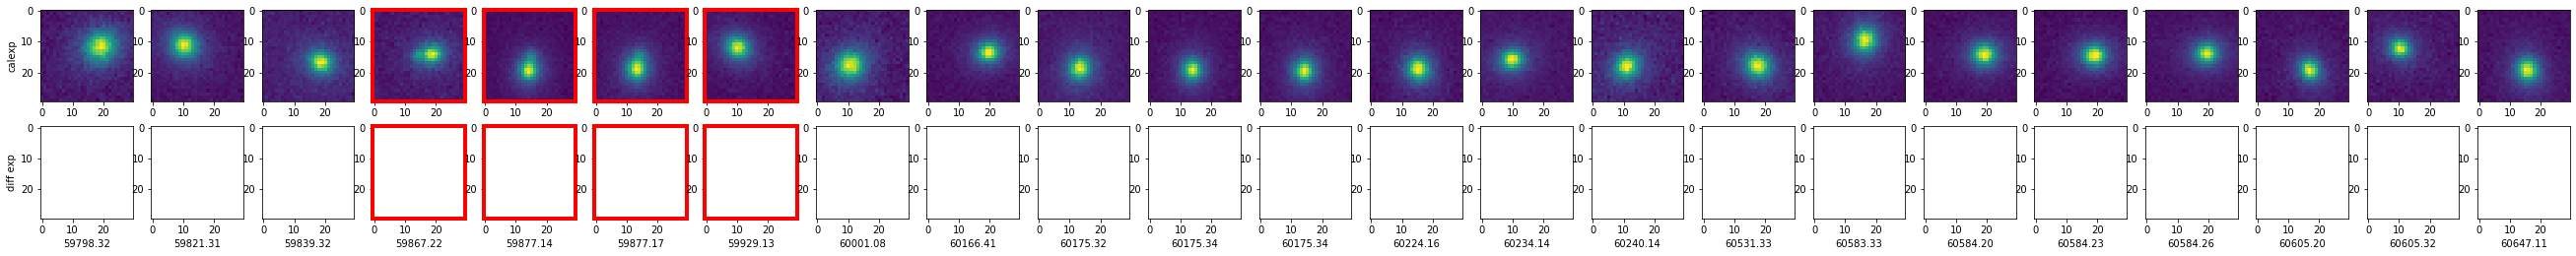

MS_9427_416 54.805588083412516 -32.36589630295243
Subplot 10, flux=2305.248046875
found diasrc match 1
Subplot 11, flux=1250.04638671875
found diasrc match 1
Subplot 12, flux=1248.1429443359375
found diasrc match 1


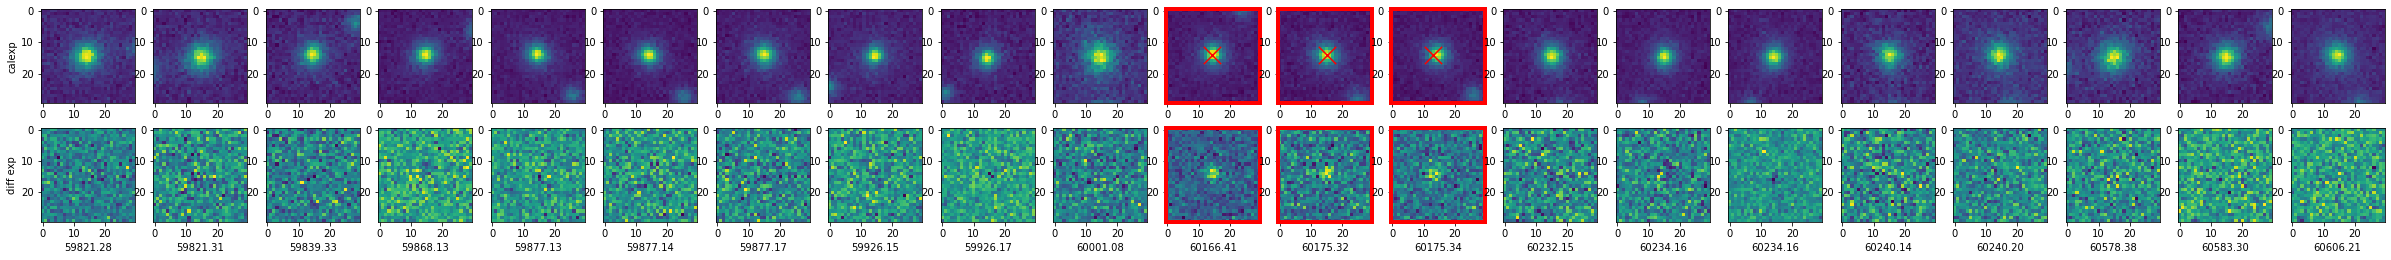

MS_9427_454 55.12977381013281 -32.37657661940774
Subplot 21, flux=1525.2576904296875
found diasrc match 1
Subplot 22, flux=1525.6561279296875
found diasrc match 1
Subplot 23, flux=4236.82470703125
found diasrc match 1
Subplot 24, flux=4236.82470703125
found diasrc match 1
Subplot 25, flux=4241.46728515625
found diasrc match 1
Subplot 26, flux=1446.0341796875
found diasrc match 1
Subplot 27, flux=502.1244812011719
Subplot 28, flux=501.62213134765625
Subplot 29, flux=375.0800476074219
Subplot 30, flux=375.0800476074219
Subplot 31, flux=374.90460205078125
Subplot 32, flux=374.8495788574219
Subplot 33, flux=374.6709899902344
Subplot 34, flux=356.9961853027344
Subplot 35, flux=356.866943359375
Subplot 36, flux=356.866943359375
Subplot 37, flux=321.412353515625
Subplot 38, flux=321.03839111328125


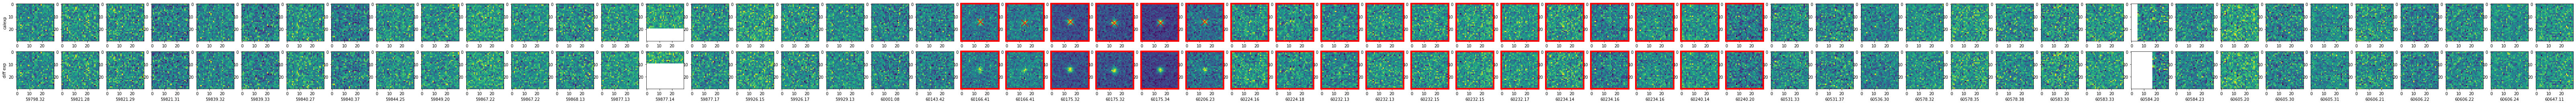

MS_9427_513 55.043710599548916 -32.29925669057861


In [ ]:
for match_idx, testSN in zip(match_sne_idx, match_sne):
    print(testSN['id'], testSN['ra'], testSN['dec'])
    testSN_visits = patch_sne_visits[match_idx]
    
    match_visits = calexp_vis[testSN_visits]
    match_mjds = mjds[testSN_visits]
    order = match_mjds.argsort()
    match_mjds = match_mjds[order]
    match_calexps = np.array(calexps_full)[testSN_visits][order]
    match_diffs = np.array(diffs)[testSN_visits][order]
    match_dia = dia_srcs[testSN_visits][order]
    
    testLC = snTruth_lcs[snTruth_lcs['id'] == testSN['id']]
    testLC_r = testLC[testLC['bandpass'] == 'r'].reset_index()
    fluxes = np.array(testLC_r['delta_flux'])
    testLC_mjds = testLC_r['MJD']
    if len(match_calexps) == 1:
        continue
    fig, subs = plt.subplots(2, len(match_calexps), figsize=(2 * len(match_calexps), 4))
    for i, calexp in enumerate(match_calexps):
        calexp_cutout = makeCutout(testSN, calexp)
        cutWcs = calexp_cutout.getWcs()
        subs[0, i].imshow(calexp_cutout.getImage().array)
        if min(abs(testLC_mjds - match_mjds[i])) < 1:
            plt.setp(subs[0,i].spines.values(), color='r', linewidth=4)
            plt.setp(subs[1,i].spines.values(), color='r', linewidth=4)
            print(f'Subplot {i}, flux={fluxes[(abs(testLC_mjds - match_mjds[i])).argmin()]}')
        if match_diffs[i] is not None:
            diff_cutout = makeCutout(testSN, match_diffs[i])
            subs[1, i].imshow(diff_cutout.getImage().array)
        subs[1, i].set_xlabel(f"{match_mjds[i]:.2f}")
        # Get dia sources:
        dia_mjd_matches = assocDiaSrcs[abs(assocDiaSrcs['midPointTai'] - match_mjds[i]) < 0.5]
        ra_dec_matches = dia_mjd_matches[(abs(dia_mjd_matches['ra'] - testSN['ra']) < 0.001) & (abs(dia_mjd_matches['decl'] - testSN['dec']) < 0.001)]
        match_dia_ra = match_dia[i]['coord_ra'] * 180 / np.pi
        match_dia_dec = match_dia[i]['coord_dec'] * 180 / np.pi
        match_dia_matches = match_dia[i][(abs(match_dia_ra - testSN['ra']) < 0.001) & (abs(match_dia_dec - testSN['dec']) < 0.001)]
        if len(ra_dec_matches) > 0:
            print("found assocDiaSrc match", len(match_dia_matches))
        if len(match_dia_matches) > 0:
            print("found diasrc match", len(match_dia_matches))
        for m, match_src in ra_dec_matches.iterrows():
            src_sp = lsst.geom.SpherePoint(match_src['ra'], match_src['decl'], lsst.geom.degrees)
            src_pix = cutWcs.skyToPixel(src_sp)
            minx = calexp_cutout.getBBox().beginX
            miny = calexp_cutout.getBBox().beginY
            subs[0, i].scatter(src_pix[0] - minx, src_pix[1] - miny, marker='+', color='orange', s=300)
        for m, match_src in enumerate(match_dia_matches):
            src_sp = lsst.geom.SpherePoint(match_src['coord_ra'] * 180 / np.pi, match_src['coord_dec'] * 180 / np.pi,
                                           lsst.geom.degrees)
            src_pix = cutWcs.skyToPixel(src_sp)
            minx = calexp_cutout.getBBox().beginX
            miny = calexp_cutout.getBBox().beginY
            subs[0, i].scatter(src_pix[0] - minx, src_pix[1] - miny, marker='x', color='r', s=300)
    subs[0,0].set_ylabel('calexp')
    subs[1,0].set_ylabel('diff exp')
    plt.show()